# A Hierarchical Model of Honeybee Waggle-Dances
---

## Details

&ensp;AUTHOR:&emsp;   James Foster &emsp; 2025 03 14

MODIFIED:&emsp; James Foster &emsp; 2025 04 03

DESCRIPTION:&emsp; Fit a hierarchical maximum-likelihood von Mises to honeybee waggle-run angles.
Modified from [beetles.ipynb](https://github.com/jgraving/unwrap/notebooks/)

            
INPUTS:&emsp;   `'colour_dance_reorg.csv'`
            
OUTPUTS:&emsp;  Plots and test statistics

CHANGES: 
- More comprehensive simulation
- Sun azimuth added to plots
- Exchanged normal priors for von Mises
- Tightened von Mises priors (20 < kappa < 40)
- Tested kappa hyperparameter priors: LogNormal(log(30), sigma = 0.1) appears optimal
- Changed coefficient priors to Normal: Normal(sigma=5*np.pi/180)
- Changed coefficient hyperparameter priors to Normal:  LogNormal( log(1° in radians), sigma=1.0 )
- Tested SkewNormal, Gamma and StudentT priors for 1|Individual hyperparameter kappa (LogNormal still faster and more stable)
- Tested 180° changes on fixef

REFERENCES:
- Sayin S, ... Graving JM, $et~al$. (2025)
The behavioral mechanisms governing collective motion in swarming locusts.
Science 387,995-1000
DOI:[10.1126/science.adq7832](https://doi.org/10.1126/science.adq7832)

- Graving JM & Foster JJ in preparation
Unwrapping Circular Statistics: Bayesian Linear Models for Circular Data

---

## To Do list
>- Find better priors for hyperparameters +
>- Test student-t priors for hyperparameters +
>- Reduce figure size (takes too long to load) +
>- Test model without UV dim (bimmodality problems) +
>- Neaten up modelling (exlude nonsensical models) +
>- Switch to Normal random effects structure on mean angle +
- Tighten prior on colour random effects
- Circular-circular model
- Build maximal model
- Convert to geographic frame of reference
- Extract predictions
- Build hypothesis tests
- Plot hypothesis tests

# First set up the required packages
Don't forget to make sure the the kernel is running in a `conda` environment.
To fit models using `g++` (recommended for speed) make sure `m2w64-toolchain` is installed on Windows.

In [58]:
#set up required packages
##JJF make sure to select a conda environment as the kernel!
##JJF to use g++, before running: conda install m2w64-toolchain
##JJF on Mac install "ipywidgets" for Jupyter support of PyMC
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install -U --no-cache git+https://github.com/jgraving/unwrap 

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
  Cloning https://github.com/jgraving/unwrap to /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-m0q46dic
  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-m0q46dic
  Resolved https://github.com/jgraving/unwrap to commit 9567136cb65fe506c37f629d43639bcbb06781c0
  Preparing metadata (setup.py) ... done
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=11654 sha256=5b915a8ae2c9d87cdd1b20cec5fb05e1c367fb3c881e0c4f50f54673c63c47e4
  Stored in directory: /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-ephem-wheel-cache-qsbpzfie/wheels/6d/a6/84/e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap


# Prepare the data
## Import and format the data
Load the preprocessed data from CSV and convert to radians. Relabel the two conditions in each factor to binary.

In [59]:

import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'colour_dance_reorg.csv'#JJF windows is having trouble finding this file
df = pd.read_csv(file_path, sep=',')

# Create a binary indicator for the light intensity (1 for 'low', 0 for 'high')
df['B'] = df['brightn'].apply(lambda x: 1 if 'l' in x else 0)
# Create a binary indicator for the light colour (1 for 'UV', 0 for 'green')
df['C'] = df['colour'].apply(lambda x: 1 if 'u' in x else 0)
# Rename sun azimuth to use capitalised label
df['SunAz'] = df['sun_az_rad']
# Rename run to use capitalised label
df['Run'] = df['run']

# Convert the dance angle column to the correct format (already radians?)
df['angle'] = pd.to_numeric(df['angle'], errors='coerce')  # Convert non-numeric values (e.g., 'NA') to NaN

# Normalise all angles to be between -pi and pi (should be already)
df['angle'] = df['angle'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)
df['sun_az_rad'] = df['sun_az_rad'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# Keep only the relevant columns and drop rows with missing values
df = df[['angle','ID', 'B', 'C', 'Run','SunAz']].dropna().copy()
df.reset_index(drop=True, inplace=True)

# Rename columns: change 'Beetle' to 'Individual'
df = df.rename(columns={'ID': 'Individual'})
df['Individual'] = df['Individual'].astype('category')

df.head()

,angle,Individual,B,C,Run,SunAz
0,-1.570796,2016.05.31.14.24,1,1,1,-2.647205
1,0.087266,2016.05.31.14.24,1,1,2,-2.647205
2,0.349066,2016.05.31.14.24,1,1,3,-2.647205
3,-0.698132,2016.05.31.14.24,1,1,4,-2.647205
4,0.349066,2016.05.31.14.24,1,1,5,-2.647205


## Inspect the data
Use Jake's plots to show the repeated angles across individuals.
Maybe limit this to just 10 individuals for now.

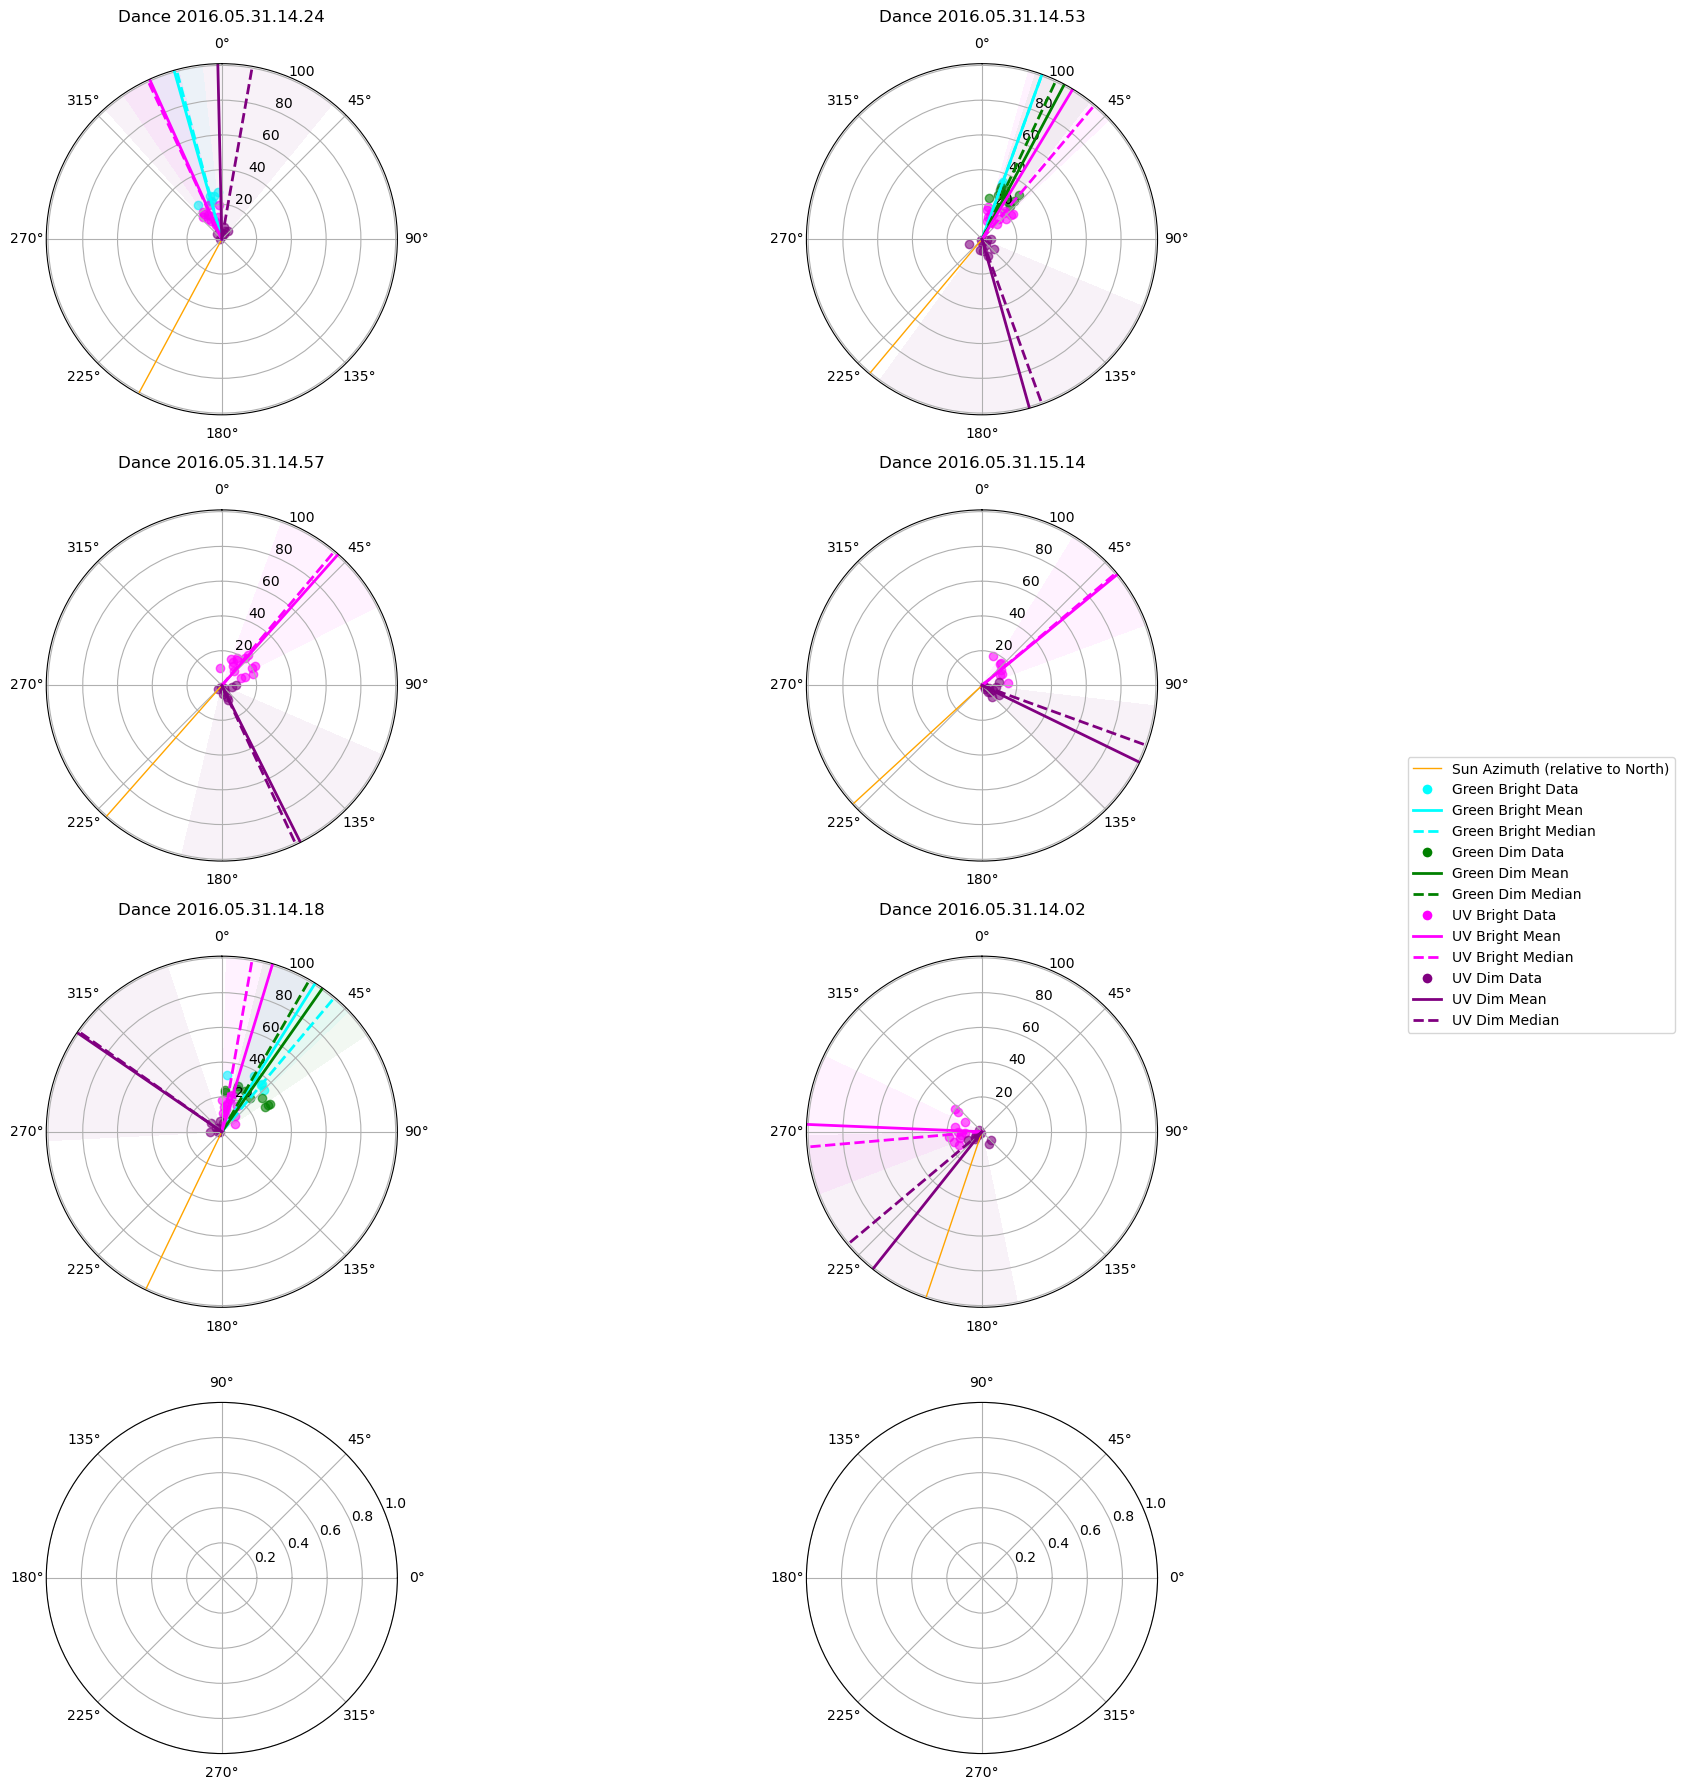

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Helper function to compute and plot summary statistics.
# It plots a solid vertical line at the circular mean and a dashed vertical line at the circular median,
# both in the specified color. It also fills the region ± the circular standard deviation.
def plot_summary_stats(ax, angles, radial_max, color):
    # Compute circular mean, median, and standard deviation.
    mean_val = circmean(angles, high=np.pi, low=-np.pi)
    median_val = circ_median(angles)
    std_val = circstd(angles, high=np.pi, low=-np.pi, normalize=True)
    
    # Plot mean (solid) and median (dashed).
    ax.plot([mean_val, mean_val], [0, radial_max], color=color, linewidth=2)
    ax.plot([median_val, median_val], [0, radial_max], color=color, linewidth=2, linestyle='--')
    
    # Fill the region between mean minus std and mean plus std.
    theta_vals = np.linspace(mean_val - std_val, mean_val + std_val, 100)
    r_vals = np.linspace(0, radial_max, 100)
    Theta, R = np.meshgrid(theta_vals, r_vals)
    ax.contourf(Theta, R, np.ones_like(Theta), alpha=0.05, colors=[color]) # was alpha = 0.2, but covers too much data
    
    return mean_val, median_val, std_val

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()
unique_individuals = unique_individuals[range(0,6)] # for now just the 1st 6 

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = ( np.intc(1+n_plots/2) , 2  ) # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(18, np.intc(n_plots*3)))
axes = axes.flatten()

# radial_max = 10*4  # Maximum radial value
radial_max = np.max(df['Run'])  # Maximum radial value (maximum runs)

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    # Set axes to geographic format (clockwise, 0° at the top)
    ax.set_theta_direction(-1)#reverse to clockwise
    ax.set_theta_zero_location('N')#place 0° at the top
    individual_data = df[df['Individual'] == individual]
    
    # Separate Light bright and Light dim data (drop NaNs in angle).
    data_on = individual_data[individual_data['B'] == 0].dropna(subset=['angle'])
    data_off = individual_data[individual_data['B'] == 1].dropna(subset=['angle'])
    # Separate bright data.
    data_gh = data_on[data_on['C'] == 0]
    data_uh = data_on[data_on['C'] == 1]
    # Separate dim data.
    data_gl = data_off[data_off['C'] == 0]
    data_ul = data_off[data_off['C'] == 1]
    
    # Scatter-plot data.
    plot_scatter(ax, data_gh, 'angle', 'Run', 'cyan', 'Green Bright')
    plot_scatter(ax, data_gl, 'angle', 'Run', 'green', 'Green Dim')
    plot_scatter(ax, data_uh, 'angle', 'Run', 'magenta', 'UV Bright')
    plot_scatter(ax, data_ul, 'angle', 'Run', 'purple', 'UV Dim')
    
    #Plot the sun's azimuth for reference
    ax.plot(individual_data['SunAz'].values[range(0,2)], [0, radial_max], color='orange', linewidth=1)
    # Plot summary statistics for each condition.
    if not data_gh.empty:
        plot_summary_stats(ax, data_gh['angle'].values, radial_max, 'cyan')
    if not data_gl.empty:
        plot_summary_stats(ax, data_gl['angle'].values, radial_max, 'green')
    if not data_uh.empty:
        plot_summary_stats(ax, data_uh['angle'].values, radial_max, 'magenta')
    if not data_ul.empty:
        plot_summary_stats(ax, data_ul['angle'].values, radial_max, 'purple')
    
    ax.set_title(f'Dance {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)

# Create a shared custom legend.
legend_handles = [
    # For sun azimuth (orange)
    Line2D([0], [0], color = 'orange', lw = 1, label = 'Sun Azimuth (relative to North)'),
    # For green bright (cyan)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=8, label='Green Bright Data'),
    Line2D([0], [0], color='cyan', lw=2, label='Green Bright Mean'),
    Line2D([0], [0], color='cyan', lw=2, linestyle='--', label='Green Bright Median'),
    # For green dim (green)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Green Dim Data'),
    Line2D([0], [0], color='green', lw=2, label='Green Dim Mean'),
    Line2D([0], [0], color='green', lw=2, linestyle='--', label='Green Dim Median'),
    # For UV bright (magenta)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='magenta', markersize=8, label='UV Bright Data'),
    Line2D([0], [0], color='magenta', lw=2, label='UV Bright Mean'),
    Line2D([0], [0], color='magenta', lw=2, linestyle='--', label='UV Bright Median'),
    # For UV dim (purple)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=8, label='UV Dim Data'),
    Line2D([0], [0], color='purple', lw=2, label='UV Dim Mean'),
    Line2D([0], [0], color='purple', lw=2, linestyle='--', label='UV Dim Median'),
]

# Add one shared legend to the right of the figure.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.10, 0.5), fontsize='medium')

plt.tight_layout()
plt.show()

# Fit a circular model with individual effects but no interactions
To begin with fit a model with only the effects of different individuals, light intensities and LED colours.

In [61]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior
from pymc import VonMises

# Set up a dataset without interactions by removing the UV-dim condition
df_noint = df[~((df['B'] == 1) & (df['C'] == 1))].copy()
#test detection of 180° rotation
df_noint['fake_angle'] = df_noint['angle']
df_noint['fake_angle'] = df_noint['fake_angle'] + df_noint['B'].apply(lambda x: np.pi if x == 1 else 0)
df_noint['fake_angle'] = df_noint['fake_angle'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x) #return to [-pi pi)


# Define the model formula with updated, capitalized variable names.
formula = bmb.Formula(
    "fake_angle ~ B + C + (1 + B + C |Individual)",
    "kappa ~ B + C + (1 + B + C |Individual)",
)

#20250402 target Intercept, B and C, as well as high C|Indiv are causing divergences

# Specify priors for the model with capitalized keys and updated variable names.
priors = {
    # Fixed effects for μ:
    # "Intercept": CircularUniformPrior(), # Unbiased prior, pop mean can be in any direction
    #20250303 appears important to help convergence, not mixing well at high concentrations
    "Intercept": bmb.Prior("VonMises", mu=0, kappa=inverse_softplus(10)), # Biased prior,expect population phototaxis
    # "B": bmb.Prior("Normal", mu=0, sigma=20*np.pi/180), # Informative prior, expect no effect of colour beyond pop mean # still converging badly, possibly because it needs the interaction
    # "C": bmb.Prior("Normal", mu=0, sigma=20*np.pi/180), # Informative prior, expect no effect of colour beyond pop mean
    #These need to be wide to account for possible 180° rotations
    # "B": bmb.Prior("Normal", mu=0, sigma=60*np.pi/180), # Wide prior, allow 180° turns; much slower
    # "C": bmb.Prior("Normal", mu=0, sigma=60*np.pi/180), # Wide prior, allow 180° turns; much slower
    "B": bmb.Prior("VonMises", mu=0, kappa=1), # Getting the right answer, but bad rhat, could circular be better?
    "C": bmb.Prior("VonMises", mu=0, kappa=1), # Getting the right answer, but bad rhat, could circular be better?
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here; large sigma slows estimation; mu=log(30), sigma=0.1 appears to be a good compromise.
    #20250402 Switched to Normal, so far no noticeable improvement
    #20250403 Individual effect sigma seems to be driving divergences, now fixed to 0.5 log units
    "1|Individual": bmb.Prior(
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.10) # Informative prior, individuals close to pop mean circsd ~10° # do not change!
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(10*np.pi/180), sigma=0.5) # Informative prior, individuals close to pop mean circsd ~10° # do not change!
    ),
    "B|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(5*np.pi/180), sigma=0.3) # Informative prior but long tails, individuals respond to brightness in the same way
    ),
    "C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(5*np.pi/180), sigma=0.3) # Informative prior but long tails, individuals respond to colour in the same way # try tightening
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1), # Weakly informative prior, the population is somewhat concentrated
        "B": bmb.Prior("Normal", mu=0, sigma=2.5), # Weak prior, changes in concentration are within 2.5 orders of magnitude
        "C": bmb.Prior("Normal", mu=0, sigma=2.5), # Weak prior, changes in concentration are within 2.5 orders of magnitude
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
        "B|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
        "C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
model = bmb.Model(
    formula,
    df_noint,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model)

# Fit the model.
idata = model.fit(draws=1500,   tune = 1500) # be prepared for this to take 10 minutes

       Formula: fake_angle ~ B + C + (1 + B + C |Individual)
                kappa ~ B + C + (1 + B + C |Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 3281
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ VonMises(mu: 0.0, kappa: 10.0)
            B ~ VonMises(mu: 0.0, kappa: 1.0)
            C ~ VonMises(mu: 0.0, kappa: 1.0)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.7456, sigma: 0.5))
            B|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -2.4388, sigma: 0.3))
            C|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -2.4388, sigma: 0.3))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
            kappa_B ~ Normal(mu: 0.0, sigma: 2.5)
            kappa_C ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            kappa_

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, B, C, 1|Individual_sigma, 1|Individual_offset, B|Individual_sigma, B|Individual_offset, C|Individual_sigma, C|Individual_offset, kappa_Intercept, kappa_B, kappa_C, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_B|Individual_sigma, kappa_B|Individual_offset, kappa_C|Individual_sigma, kappa_C|Individual_offset]


Output()

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 174 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics

#### 20250324 Best convergence obtained with these priors on fixed effects

| coef | mean | sd | hdi_3% | hdi_97% | mcse_mean | mcse_sd | ess_bulk | ess_tail | r_hat | prior |
| :------ | :------: | :------: | :------: | :------: | :------: | :------: | :------: | :------: | :------: | :------: |
| Intercept	|-0.345 | 0.063	| -0.460| -0.224| 0.001 | 0.001 | 919.0 | 1806.0 | 1.0 | CircularUniformPrior() |
| B	| 0.472	| 0.148	| 0.191	| 0.743	| 0.003	| 0.003	| 1530.0 | 2478.0 | 1.0  | "Normal", mu=0, sigma=20*np.pi/180 |
| C	| -0.076 | 0.090 | -0.238 | 0.098 | 0.002 | 0.002 | 735.0 | 1080.0	| 1.0 | "Normal", mu=0, sigma=20*np.pi/180 |
| kappa_Intercept	| 4.329	| 0.287	| 3.800	| 4.873	| 0.005	| 0.003	| 3524.0	| 3000.0	| 1.0 | "Normal", mu=inverse_softplus(2), sigma=1 |
| kappa_B	| -3.063	| 0.325	| -3.629	| -2.426	| 0.006	| 0.004	| 3471.0	| 2993.0	| 1.0 | "Normal", mu=0, sigma=2.5 |
| kappa_C	| 4.176	| 0.373	| 3.478	| 4.867	| 0.006	| 0.004	| 3891.0	| 3324.0	| 1.0 | "Normal", mu=0, sigma=2.5 |

Other priors
| coef | prior |
| :---- | :----: |
| 1\|Individual | "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.10) |
| B\|Individual | "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(5*np.pi/180), sigma=1.0) |
| C\|Individual | "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(5*np.pi/180), sigma=1.0) |

C|individual sigma is still having trouble converging towards 0.9 = 52°. Could try loosening that prior.

#### 20250325
It appears that the model has difficulty distinguishing between lower concentration of the individual responses to colour and determining the mean angle for colour.
Since we expect high similarity between individuals, this prior has now been biased towards zero difference. Seems to produce more stable estimates.
**On closer inspection, this destroyed the fixed effects coefficients, REMOVED**
| coef | prior |
| :---- | :----: |
| 1\|Individual | "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.10) |
| B\|Individual | "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(1*np.pi/180), sigma=1.5) |
| C\|Individual | "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(1*np.pi/180), sigma=1.5) |


In [62]:
#check convergence heuristics
#All converged quite well with the 20250324 priors, except B
az.summary(
    idata, 
    var_names=["Intercept",
               "B", # originally slightly right shifted, should converge to around -2.716
                "C",
                "kappa_Intercept",
               "kappa_B",
                "kappa_C",
                ],
    circ_var_names=["Intercept",
                    "B",
                    "C",
                    ]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.289,0.093,-0.459,-0.119,0.006,0.006,115.0,220.0,1.04
B,-2.700,0.130,-2.951,-2.459,0.005,0.004,626.0,775.0,1.01
C,-0.103,0.033,-0.164,-0.041,0.000,0.000,3131.0,4350.0,1.00
kappa_Intercept,4.497,0.279,4.000,5.042,0.005,0.004,3135.0,4223.0,1.00
kappa_B,-3.248,0.328,-3.872,-2.658,0.007,0.005,2488.0,3659.0,1.00
kappa_C,3.956,0.363,3.271,4.638,0.006,0.004,4020.0,4778.0,1.00


In [63]:
#check convergence heuristics on random effects
az.summary(
    idata, 
    var_names=[
        # "1|Individual_kappa",
        "1|Individual_sigma",
        "B|Individual_sigma",
        "C|Individual_sigma",
        "kappa_1|Individual_sigma",
        "kappa_B|Individual_sigma",
        "kappa_C|Individual_sigma",
                ],
    # filter_vars='like',
    # circ_var_names=[]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|Individual_sigma,1.095,0.063,0.976,1.209,0.003,0.002,369.0,758.0,1.03
B|Individual_sigma,0.609,0.088,0.439,0.770,0.003,0.002,1137.0,1208.0,1.00
C|Individual_sigma,0.103,0.030,0.048,0.158,0.001,0.001,486.0,857.0,1.01
kappa_1|Individual_sigma,0.997,0.101,0.812,1.187,0.002,0.001,3465.0,3910.0,1.00
kappa_B|Individual_sigma,0.546,0.057,0.442,0.653,0.001,0.001,6659.0,4789.0,1.00
kappa_C|Individual_sigma,0.548,0.059,0.441,0.660,0.001,0.000,8270.0,4541.0,1.00


## Visualise output of simple model
This one doesn't include interaction terms.

- The "Intercept" is the condition: **Green, Bright**
- B is the effect dimming the light: **Green, Dim**
- C is the effect of switching to UV: **UV, Bright**
- The simple addition of effects for B and C would give: **UV, Dim**

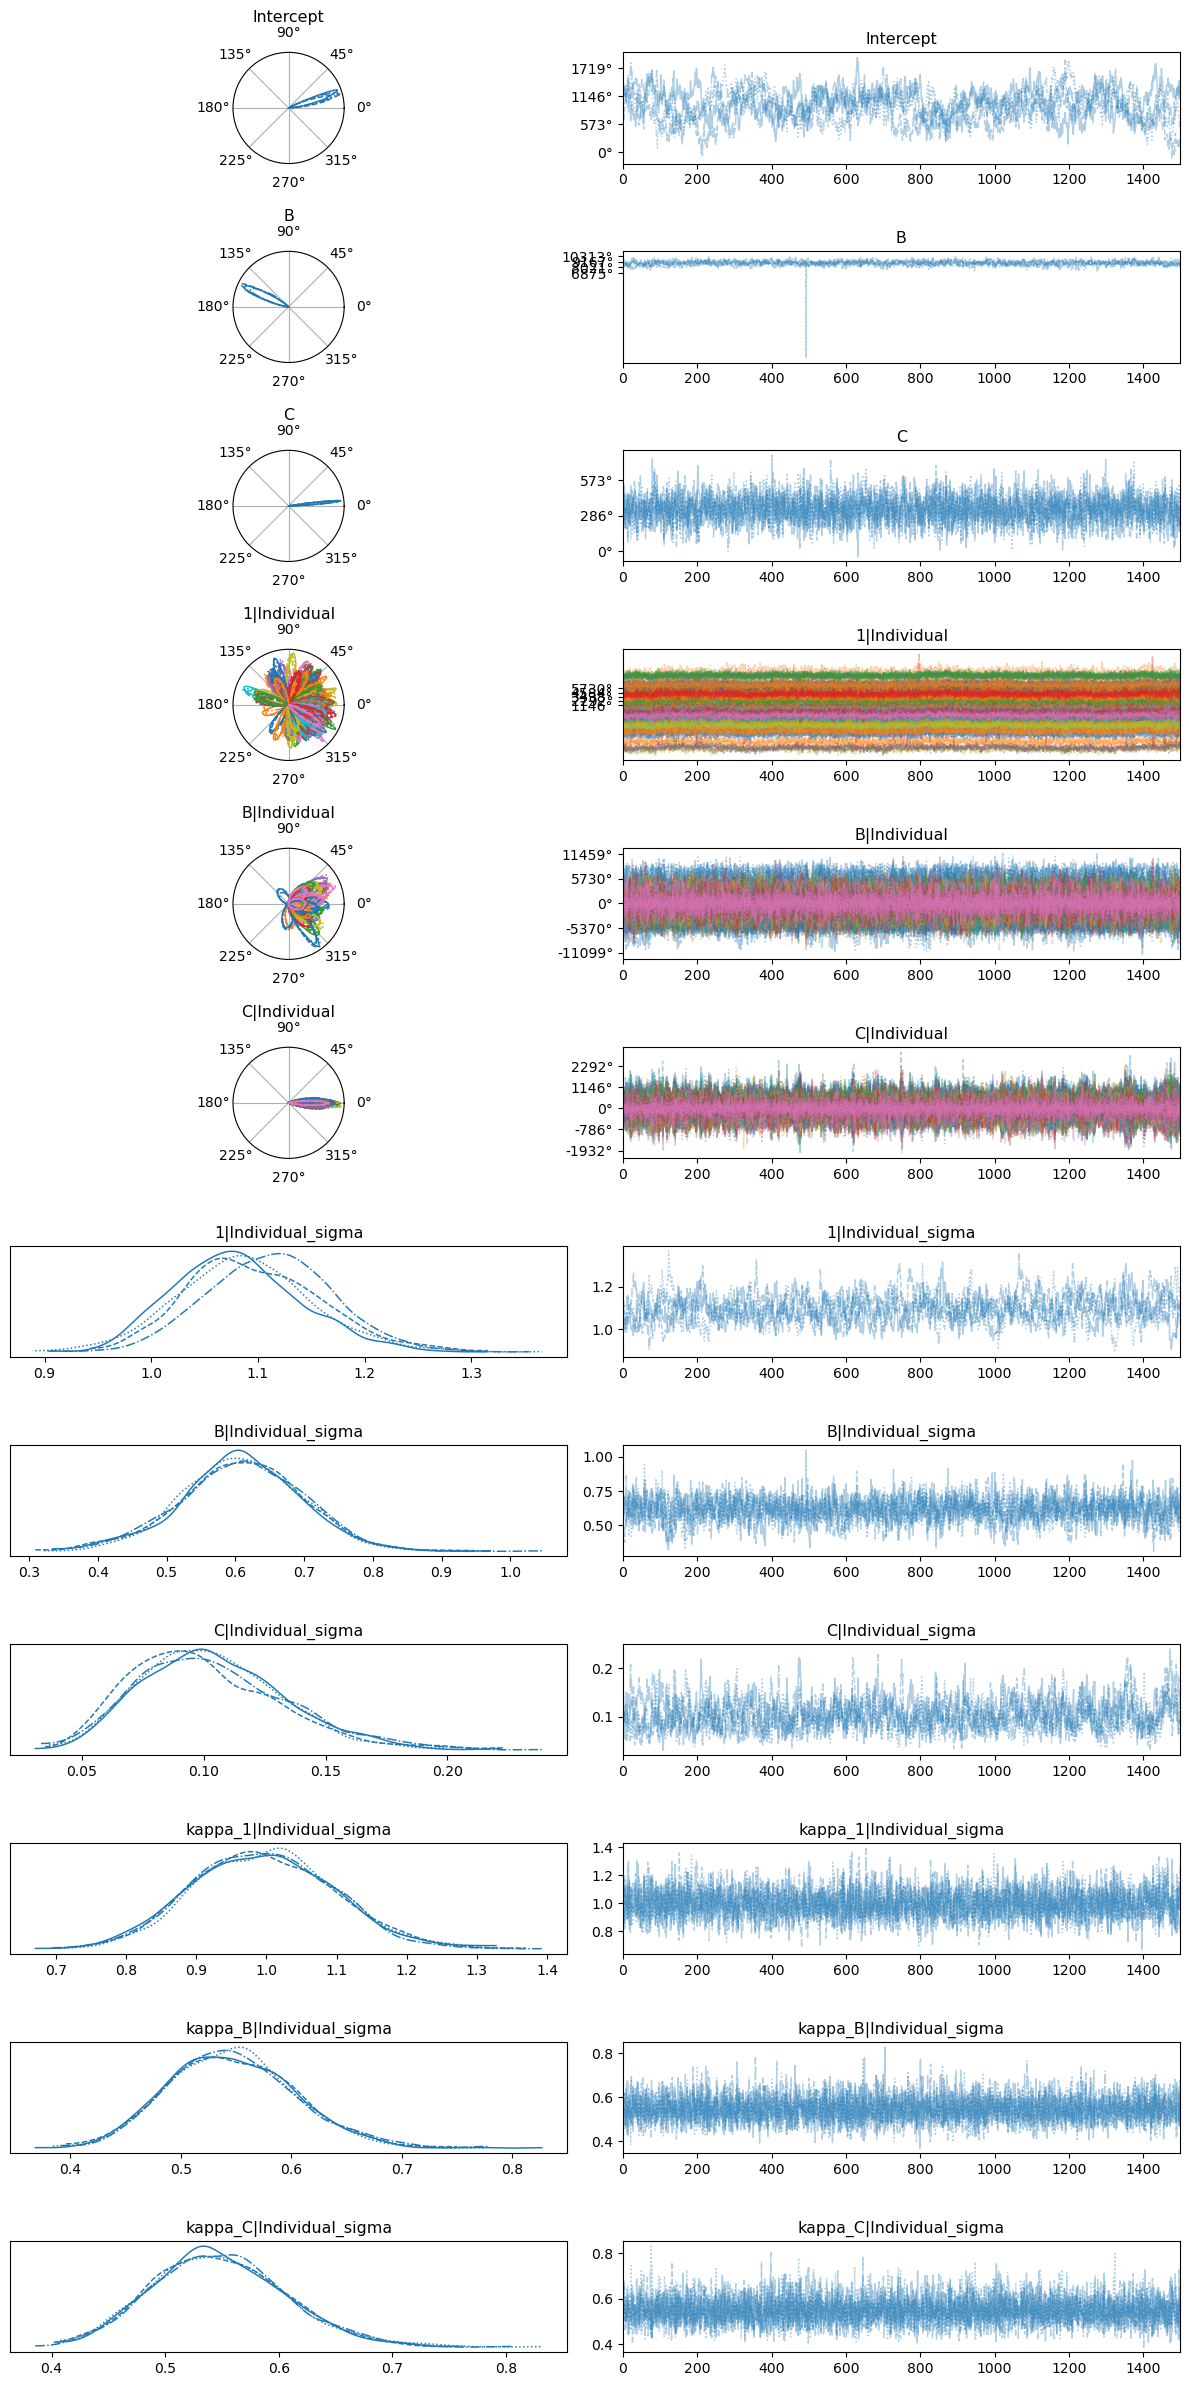

In [64]:
#Specify which parameters are circular
vars=[
        "Intercept",
        "B",
        "C",
        "1|Individual",
        "B|Individual",
        "C|Individual",
        # "1|Individual_kappa",
        "1|Individual_sigma",
        "B|Individual_sigma",
        "C|Individual_sigma",
        "kappa_1|Individual_sigma",
        "kappa_B|Individual_sigma",
        "kappa_C|Individual_sigma",
       ]
cvars = ["Intercept",
        "B",
        "C",
        "1|Individual",
        "B|Individual",
        "C|Individual",
        # "1|Individual_sigma", # sometimes useful to see on circ scale when small
        # "B|Individual_sigma",
        # "C|Individual_sigma",
        ]
#transform the circular data for interpretability
idata_trans = idata.copy() # set up a variable for transformed data
for cvar in cvars:
    idata_trans.posterior[cvar] = -180*idata_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_trans,
              var_names= vars,
              circ_var_names=cvars,
              circ_var_units='degrees') #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()#without divergences takes about 30s

# Attempt to fit a model with interactions in the random effects
Include the possibility for each individual bee to respond differently to the dim UV light.
This might be more challenging for the random-effects on mean angle. Another challenge may be multimodality in the data for UV-dim.

Currently appears that it is just slower to run the additional parameters.
Expect this to take `~15` minutes for `1000` draws.

In [38]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_intID = bmb.Formula(
    "angle ~ B + C + B:C + (1 + B + C + B:C  |Individual)",
    "kappa ~ B + C + B:C + (1 + B + C + B:C  |Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_intID = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "B": bmb.Prior("Normal", mu=0, sigma=20*np.pi/180), #Good rhat: sigma = 3°
    "C": bmb.Prior("Normal", mu=0, sigma=20*np.pi/180), #Good rhat: sigma = 3°
    "B:C": bmb.Prior("Normal", mu=0, sigma=20*np.pi/180), #OK rhat: sigma = 90° #Convergence problems because of multimodality 90° and -45° both common dep on dance
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.1) # good rhat
    ),
    "B|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(5*np.pi/180), sigma=1.0) # good rhat mu = 1°, now loosened
    ),
    "C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(5*np.pi/180), sigma=1.0) # good rhat mu = 1°, now loosened
    ),
    "B:C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(5*np.pi/180), sigma=1.0) #good rhat mu = 1°, now loosened
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "B": bmb.Prior("Normal", mu=0, sigma=2.5),
        "C": bmb.Prior("Normal", mu=0, sigma=2.5),
        "B:C": bmb.Prior("Normal", mu=0, sigma=1.25), # Jake reckons this prior should be smaller because it is an intercept with larger uncertainty
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "B|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "B:C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1) #tightened
        ),
    },
}

# Build the model using the updated formula and priors.
model_intID = bmb.Model(
    formula_intID,
    df,
    family="vonmises",
    priors=priors_intID,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_intID)

# Fit the model.
idata_intID = model_intID.fit(draws=1000, tune=1000) # be prepared for this to take a very long time to run on Windows!

       Formula: angle ~ B + C + B:C + (1 + B + C + B:C  |Individual)
                kappa ~ B + C + B:C + (1 + B + C + B:C  |Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 5774
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            B ~ Normal(mu: 0.0, sigma: 0.3491)
            C ~ Normal(mu: 0.0, sigma: 0.3491)
            B:C ~ Normal(mu: 0.0, sigma: 0.3491)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.1))
            B|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -2.4388, sigma: 1.0))
            C|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -2.4388, sigma: 1.0))
            B:C|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -2.4388, sigma: 1.0))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
       

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, B, C, B:C, 1|Individual_kappa, 1|Individual, B|Individual_sigma, B|Individual_offset, C|Individual_sigma, C|Individual_offset, B:C|Individual_sigma, B:C|Individual_offset, kappa_Intercept, kappa_B, kappa_C, kappa_B:C, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_B|Individual_sigma, kappa_B|Individual_offset, kappa_C|Individual_sigma, kappa_C|Individual_offset, kappa_B:C|Individual_sigma, kappa_B:C|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 874 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


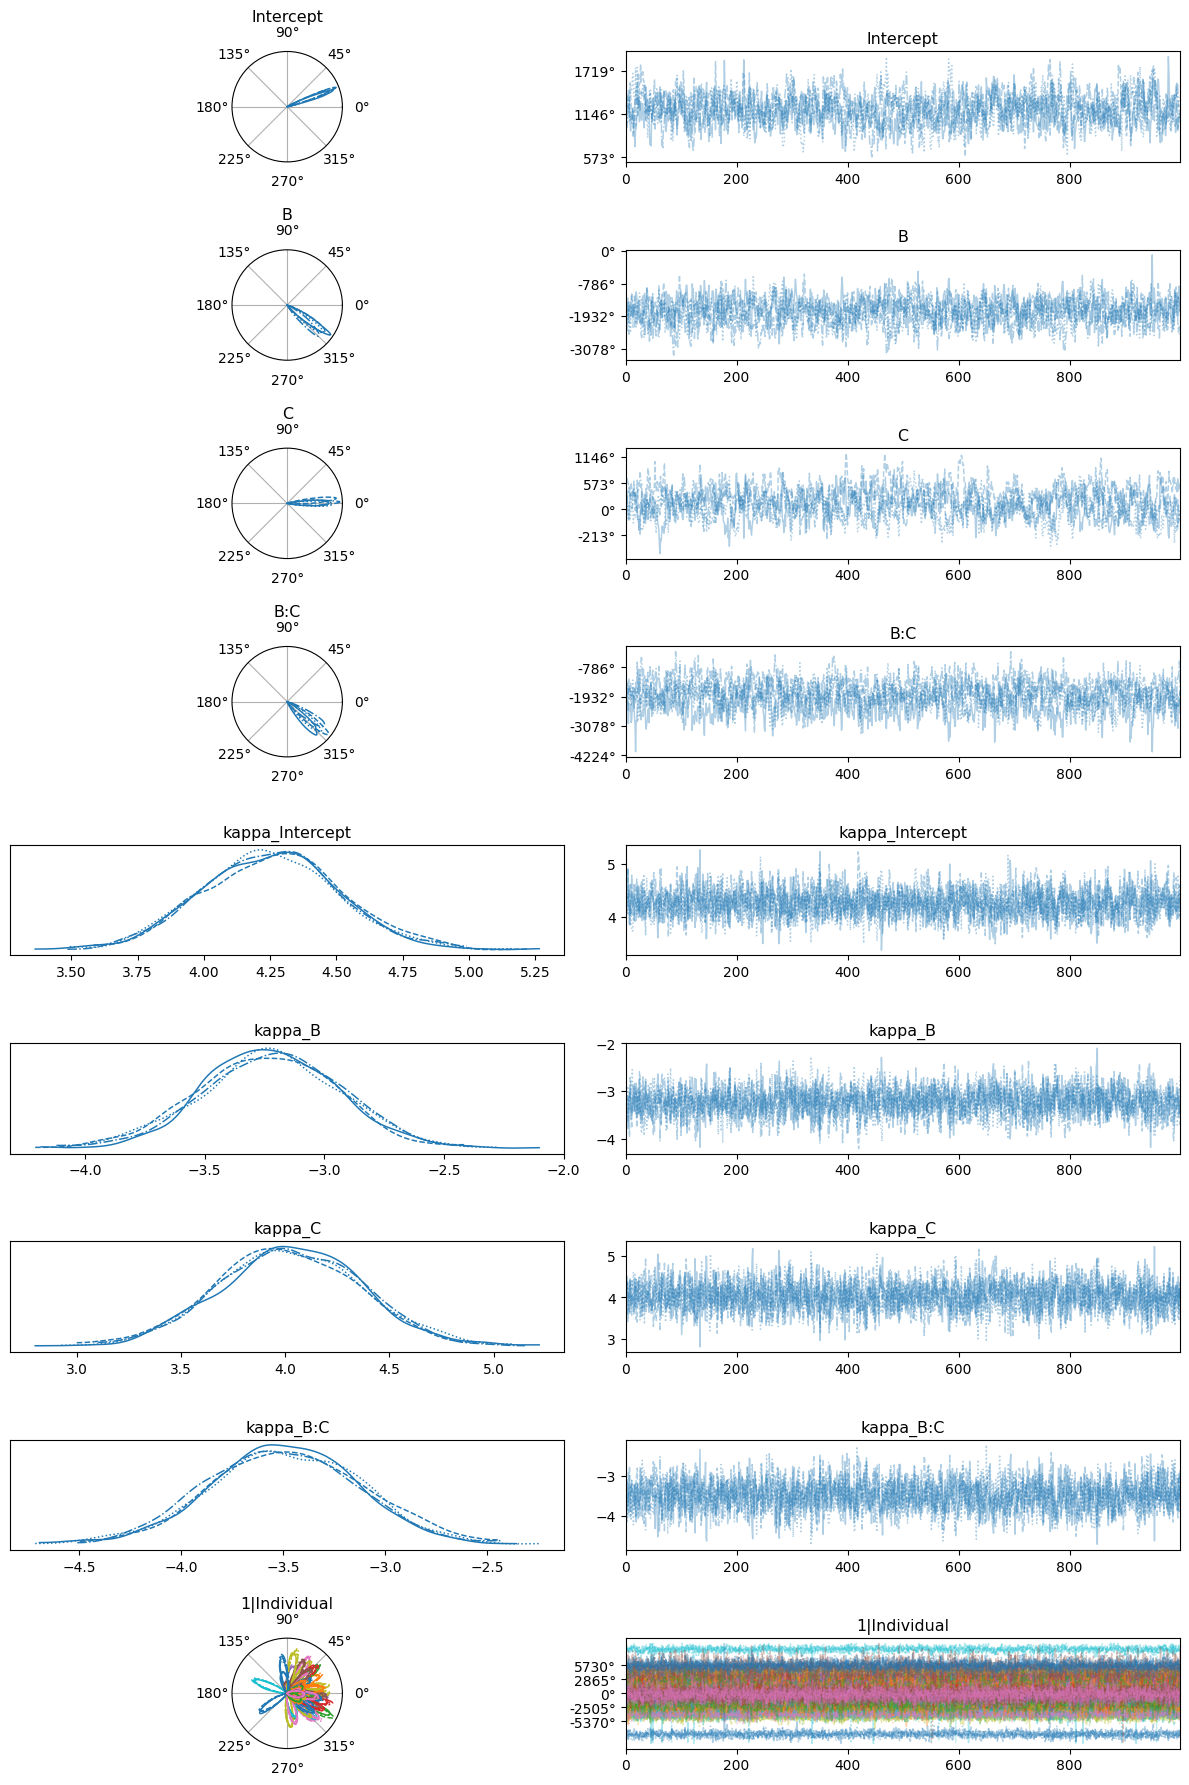

In [41]:
#Specify which parameters are circular
cvars = ["Intercept",
        "B",
        "C",
        "B:C",
        "1|Individual",
        "B|Individual",
        "C|Individual",
        "B:C|Individual",
        ]
#transform the circular data for interpretability
idata_intID_trans = idata_intID # set up a variable for transformed data
for cvar in cvars:
    idata_intID_trans.posterior[cvar] = -180*idata_intID_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_intID_trans,
              var_names=["Intercept",
               "B",
                "C",
                "B:C",
                "kappa_Intercept",
               "kappa_B",
                "kappa_C",
                "kappa_B:C",
                "1|Individual"
                ],
            circ_var_names=cvars,
            circ_var_units='degrees',#now in degrees and going clockwise, but axis labels are anticlock and start at right
             ) #make sure all parameters can be plotted
plt.tight_layout()
plt.show()

In [39]:

az.summary(
    idata_intID, 
    var_names=["Intercept",
               "B",
                "C",
                "B:C",
                "kappa_Intercept",
               "kappa_B",
                "kappa_C",
                "kappa_B:C",
                ],
    circ_var_names=["Intercept",
                    "B",
                    "C",
                    "B:C",
                    ]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.369,0.062,-0.489,-0.258,0.004,0.002,668.0,1063.0,1.01
B,0.652,0.137,0.406,0.917,0.022,0.019,28.0,153.0,1.11
C,-0.039,0.096,-0.208,0.147,0.015,0.016,20.0,98.0,1.14
B:C,0.695,0.165,0.392,1.011,0.037,0.032,14.0,134.0,1.21
kappa_Intercept,4.253,0.258,3.774,4.738,0.006,0.004,1963.0,2629.0,1.00
kappa_B,-3.226,0.286,-3.769,-2.696,0.007,0.005,1897.0,2665.0,1.00
kappa_C,4.021,0.341,3.382,4.660,0.007,0.005,2220.0,3061.0,1.00
kappa_B:C,-3.492,0.368,-4.188,-2.799,0.008,0.006,2026.0,2591.0,1.00


was

| - | mean	sd	hdi_3%	hdi_97%	mcse_mean	mcse_sd	ess_bulk	ess_tail | r_hat |

| Intercept | -0.334	0.056	-0.444	-0.229	0.005	0.003	255.0	990.0 | 1.04 |

| B | 0.076	0.049	-0.012	0.174	0.002	0.001	3285.0	3499.0 | 1.00 |

| C | -0.023	0.047	-0.108	0.066	0.003	0.002	349.0	2328.0 | 1.02 |

| B:C | 1.167	0.130	0.931	1.423	0.015	0.011	69.0	938.0 | 1.05 |

| kappa_Intercept | 4.271	0.258	3.806	4.770	0.006	0.004	1835.0	2545.0 | 1.00 |

| kappa_B | -3.246	0.296	-3.823	-2.717	0.007	0.005	1973.0	2435.0 | 1.00 |

| kappa_C | 3.996	0.348	3.325	4.645	0.008	0.006	1853.0	2737.0 | 1.00 |

| kappa_B:C | -3.466	0.377	-4.174	-2.770	0.009	0.006	1778.0	2734.0 | 1.00 |


In [40]:

az.summary(
    idata_intID, 
    circ_var_names=["Intercept", "1|Individual"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|Individual[2016.05.31.14.02],-0.153,0.340,-0.761,0.530,0.005,0.005,2926.0,2392.0,1.0
1|Individual[2016.05.31.14.18],0.746,0.182,0.400,1.078,0.006,0.003,2403.0,3038.0,1.0
1|Individual[2016.05.31.14.24],0.069,0.173,-0.241,0.397,0.005,0.003,2329.0,2613.0,1.0
1|Individual[2016.05.31.14.53],0.358,0.231,-0.059,0.809,0.002,0.004,2144.0,2512.0,1.0
1|Individual[2016.05.31.14.57],0.154,0.340,-0.522,0.769,0.008,0.005,3060.0,2315.0,1.0
...,...,...,...,...,...,...,...,...,...
kappa_C|Individual[2016.09.29.14.52],-0.041,0.530,-1.060,0.920,0.007,0.008,5618.0,3239.0,1.0
kappa_C|Individual[2016.09.29.15.15],0.123,0.545,-0.924,1.078,0.007,0.008,5614.0,3538.0,1.0
kappa_C|Individual[2016.09.29.15.43],0.277,0.540,-0.785,1.241,0.007,0.007,6310.0,3575.0,1.0
kappa_C|Individual_sigma,0.604,0.064,0.487,0.724,0.001,0.001,2428.0,2753.0,1.0


## Extract & inspect posterior samples

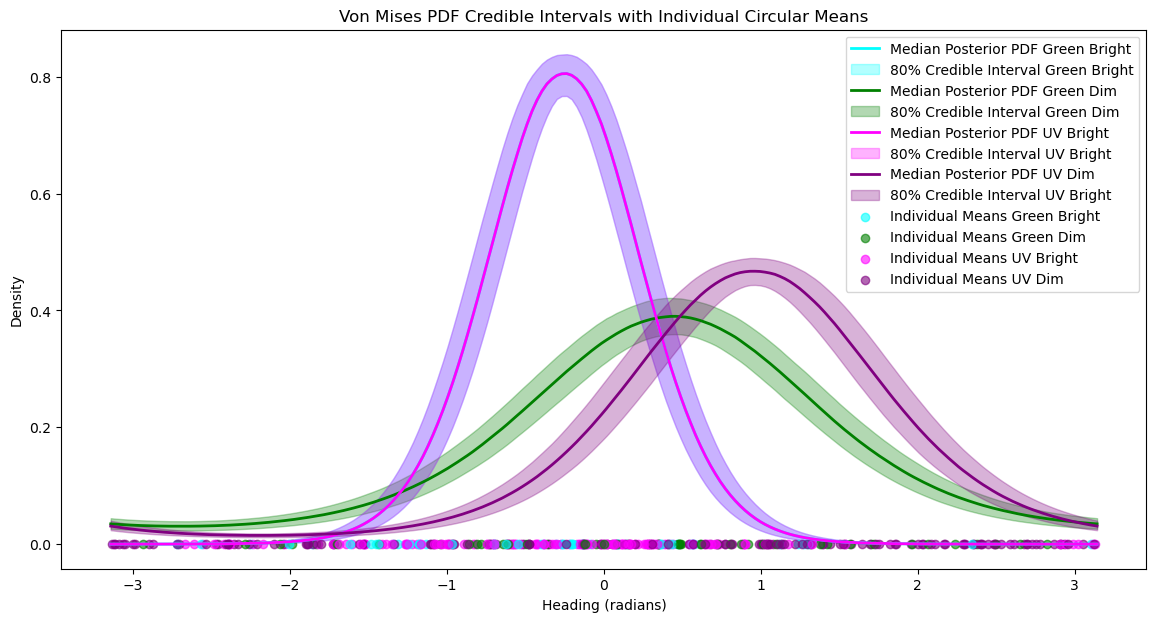

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises, circmean

# Import shifted_modulo and softplus from unwrap.link.numpy
from unwrap.link.numpy import shifted_modulo, softplus

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_intID.posterior['Intercept'].values          # fixed intercept for μ
mu_slopeB    = idata_intID.posterior['B'].values               # fixed slope for μ # Not working?
mu_slopeC    = idata_intID.posterior['C'].values               # fixed slope for μ # Not the right name?
mu_slopeBC   = idata_intID.posterior['B:C'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_intID.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slopeB    = idata_intID.posterior['kappa_B'].values        # fixed slope for κ (linear predictor)
kappa_slopeC    = idata_intID.posterior['kappa_C'].values        # fixed slope for κ (linear predictor)
kappa_slopeBC   = idata_intID.posterior['kappa_B:C'].values        # fixed slope for κ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_gh_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_gl_samples_all  = shifted_modulo((mu_intercept + mu_slopeB).flatten())
mu_pop_uh_samples_all  = shifted_modulo((mu_intercept + mu_slopeC).flatten())
mu_pop_ul_samples_all  = shifted_modulo((mu_intercept + mu_slopeB + mu_slopeC + mu_slopeBC).flatten())
kappa_pop_gh_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_gl_samples_all  = softplus((kappa_intercept + kappa_slopeB).flatten())
kappa_pop_uh_samples_all  = softplus((kappa_intercept + kappa_slopeC).flatten())
kappa_pop_ul_samples_all  = softplus((kappa_intercept + kappa_slopeB + kappa_slopeC + kappa_slopeBC).flatten())

# --------------------------------------------------
# Compute the von Mises PDF for each posterior sample at each theta.
# The resulting arrays have shape (num_samples, len(theta)).
# --------------------------------------------------
pdf_gh = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_gh_samples_all[:, None],
    loc=mu_pop_gh_samples_all[:, None]
)
pdf_gl = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_gl_samples_all[:, None],
    loc=mu_pop_gl_samples_all[:, None]
)
pdf_uh = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_uh_samples_all[:, None],
    loc=mu_pop_uh_samples_all[:, None]
)
pdf_ul = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_ul_samples_all[:, None],
    loc=mu_pop_ul_samples_all[:, None]
)

# For each theta, compute the median and the 95% credible interval. #JJF this appears to be the 80%CI!
median_pdf_gh = np.median(pdf_gh, axis=0)
lower_pdf_gh  = np.percentile(pdf_gh, 10, axis=0)
upper_pdf_gh  = np.percentile(pdf_gh, 90, axis=0)

median_pdf_gl = np.median(pdf_gl, axis=0)
lower_pdf_gl  = np.percentile(pdf_gl, 10, axis=0)
upper_pdf_gl  = np.percentile(pdf_gl, 90, axis=0)

median_pdf_uh = np.median(pdf_gh, axis=0)
lower_pdf_uh  = np.percentile(pdf_gh, 10, axis=0)
upper_pdf_uh  = np.percentile(pdf_gh, 90, axis=0)

median_pdf_ul = np.median(pdf_ul, axis=0)
lower_pdf_ul  = np.percentile(pdf_ul, 10, axis=0)
upper_pdf_ul  = np.percentile(pdf_ul, 90, axis=0)

# --------------------------------------------------
# Plot the median PDFs and fill between the 95% credible intervals.
# --------------------------------------------------
ax.plot(theta, median_pdf_gh, color='cyan', lw=2, label='Median Posterior PDF Green Bright')
ax.fill_between(theta, lower_pdf_gh, upper_pdf_gh, color='cyan', alpha=0.3,
                label='80% Credible Interval Green Bright')

ax.plot(theta, median_pdf_gl, color='green', lw=2, label='Median Posterior PDF Green Dim')
ax.fill_between(theta, lower_pdf_gl, upper_pdf_gl, color='green', alpha=0.3,
                label='80% Credible Interval Green Dim')

ax.plot(theta, median_pdf_uh, color='magenta', lw=2, label='Median Posterior PDF UV Bright')
ax.fill_between(theta, lower_pdf_uh, upper_pdf_uh, color='magenta', alpha=0.3,
                label='80% Credible Interval UV Bright')

ax.plot(theta, median_pdf_ul, color='purple', lw=2, label='Median Posterior PDF UV Dim')
ax.fill_between(theta, lower_pdf_ul, upper_pdf_ul, color='purple', alpha=0.3,
                label='80% Credible Interval UV Bright')

# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_gh = individual_data.loc[(individual_data['B'] == 0) & (individual_data['C'] == 0), 'angle'].dropna()
    headings_gl = individual_data.loc[(individual_data['B'] == 1) & (individual_data['C'] == 0), 'angle'].dropna()
    headings_uh = individual_data.loc[(individual_data['B'] == 0) & (individual_data['C'] == 1), 'angle'].dropna()
    headings_ul = individual_data.loc[(individual_data['B'] == 1) & (individual_data['C'] == 1), 'angle'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_gh = shifted_modulo(circmean(headings_gh))
    individual_circmean_gl  = shifted_modulo(circmean(headings_gl))
    individual_circmean_uh = shifted_modulo(circmean(headings_uh))
    individual_circmean_ul  = shifted_modulo(circmean(headings_ul))
    
    # Plot individual circular means.
    ax.scatter(individual_circmean_gh, 0, color='cyan', alpha=0.6,
               label='Individual Means Green Bright' if i == 0 else "")
    ax.scatter(individual_circmean_gl, 0, color='green', alpha=0.6,
               label='Individual Means Green Dim' if i == 0 else "")
    ax.scatter(individual_circmean_uh, 0, color='magenta', alpha=0.6,
               label='Individual Means UV Bright' if i == 0 else "")
    ax.scatter(individual_circmean_ul, 0, color='purple', alpha=0.6,
               label='Individual Means UV Dim' if i == 0 else "")

ax.set_title('Von Mises PDF Credible Intervals with Individual Circular Means')
ax.set_xlabel('Heading (radians)')
ax.set_ylabel('Density')
ax.legend()
plt.show()

# Fit model including effect of sun azimuth
It seems likely that some dances may be for the same location, but shifting with the sun's location.
If I have understood correctly, circular–circular regression does not require any special syntax in the `unwrap` helper for `bambi`. 

In [ ]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_intIDaz = bmb.Formula(
    "angle ~ B + C + B:C + Run + SunAz + (1 + B + C + B:C + Run |Individual)",
    "kappa ~ B + C + B:C + Run + (1 + B + C + B:C + Run |Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_intIDaz = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "B": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180),
    "C": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180),
    "B:C": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180),
    "SunAz": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180),
    "Run": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180),
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.1)
    ),
    "B|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(1*np.pi/180), sigma=1.0)
    ),
    "C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(1*np.pi/180), sigma=1.0)
    ),
    "B:C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(1*np.pi/180), sigma=1.0)
    ),
    "Run|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(1*np.pi/180), sigma=1.0)
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "B": bmb.Prior("Normal", mu=0, sigma=2.5),
        "C": bmb.Prior("Normal", mu=0, sigma=2.5),
        "B:C": bmb.Prior("Normal", mu=0, sigma=1.25), # Jake reckons this prior should be smaller because it is an intercept with larger uncertainty
        "Run": bmb.Prior("Normal", mu=0, sigma=2.5), # Not sure if this should be constrained
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "B|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "B:C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
        ),
        "Run|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model_intIDaz = bmb.Model(
    formula_intIDaz,
    df,
    family="vonmises",
    priors=priors_intIDaz,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_intIDaz)

# Fit the model.
idata_intIDaz = model_intIDaz.fit(draws=1000) # be prepared for this to take a very long time to run on Windows!

       Formula: angle ~ B + C + B:C + SunAz + (1 + B + C + B:C |Individual)
                kappa ~ B + C + B:C + (1 + B + C + B:C |Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 5774
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            B ~ Normal(mu: 0.0, sigma: 0.3142)
            C ~ Normal(mu: 0.0, sigma: 0.3142)
            B:C ~ Normal(mu: 0.0, sigma: 0.1571)
            SunAz ~ Normal(mu: 0.0, sigma: 0.3142)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 1.6094, sigma: 0.1))
            B|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
            C|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
            B:C|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
    target = kappa
        Common-level effects
           

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, B, C, B:C, SunAz, 1|Individual_kappa, 1|Individual, B|Individual_sigma, B|Individual_offset, C|Individual_sigma, C|Individual_offset, B:C|Individual_sigma, B:C|Individual_offset, kappa_Intercept, kappa_B, kappa_C, kappa_B:C, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_B|Individual_sigma, kappa_B|Individual_offset, kappa_C|Individual_sigma, kappa_C|Individual_offset, kappa_B:C|Individual_sigma, kappa_B:C|Individual_offset]


/opt/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 695 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:

az.summary(
    idata_intIDaz, 
    var_names=["Intercept",
               "SunAz",
               "B",
                "C",
                "B:C",
                "kappa_Intercept",
               "kappa_B",
                "kappa_C",
                "kappa_B:C",
                ],
    circ_var_names=["Intercept",
                    "SunAz",
                    "B",
                    "C",
                    "B:C",
                    ]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.318,0.112,-0.529,-0.110,0.003,0.003,770.0,1312.0,1.01
SunAz,-0.036,0.041,-0.114,0.040,0.001,0.001,838.0,1206.0,1.00
B,0.662,0.098,0.471,0.839,0.006,0.007,102.0,862.0,1.03
C,-0.076,0.047,-0.166,0.010,0.001,0.001,2149.0,2462.0,1.00
B:C,0.563,0.097,0.379,0.741,0.008,0.005,169.0,2436.0,1.02
kappa_Intercept,4.451,0.250,3.941,4.881,0.004,0.003,3339.0,2929.0,1.00
kappa_B,-3.493,0.290,-4.040,-2.951,0.005,0.004,2985.0,3030.0,1.00
kappa_C,3.808,0.344,3.147,4.440,0.006,0.004,3611.0,3081.0,1.00
kappa_B:C,-3.224,0.371,-3.916,-2.527,0.007,0.005,3203.0,2776.0,1.00


In [ ]:

az.summary(
    idata_intIDaz, 
    circ_var_names=["Intercept", "1|Individual"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.318,0.112,-0.529,-0.110,0.003,0.003,770.0,1312.0,1.01
B,0.662,0.098,0.471,0.839,0.010,0.007,102.0,862.0,1.03
C,-0.076,0.047,-0.166,0.010,0.001,0.001,2149.0,2462.0,1.00
B:C,0.563,0.097,0.379,0.741,0.007,0.005,169.0,2436.0,1.02
SunAz,-0.036,0.041,-0.114,0.040,0.001,0.001,838.0,1206.0,1.00
...,...,...,...,...,...,...,...,...,...
kappa_B:C|Individual[2016.09.27.15.52],-0.065,0.548,-1.117,0.936,0.007,0.009,6914.0,3183.0,1.00
kappa_B:C|Individual[2016.09.29.14.21],-0.196,0.539,-1.210,0.837,0.006,0.008,7563.0,3195.0,1.00
kappa_B:C|Individual[2016.09.29.14.52],0.012,0.541,-1.040,0.984,0.008,0.009,5101.0,3079.0,1.00
kappa_B:C|Individual[2016.09.29.15.15],0.140,0.555,-0.918,1.133,0.007,0.009,5727.0,2929.0,1.00


## Extract & inspect posterior samples for sun azmimuth model

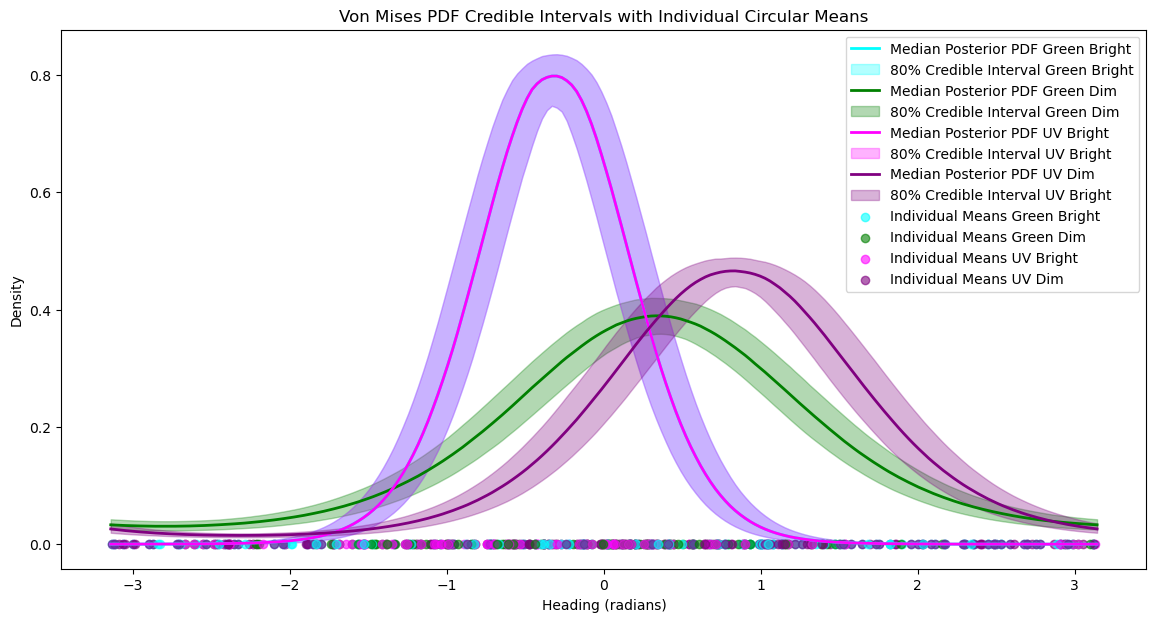

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises, circmean

# Import shifted_modulo and softplus from unwrap.link.numpy
from unwrap.link.numpy import shifted_modulo, softplus

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_intIDaz.posterior['Intercept'].values          # fixed intercept for μ
mu_slopeB    = idata_intIDaz.posterior['B'].values               # fixed slope for μ # Not working?
mu_slopeC    = idata_intIDaz.posterior['C'].values               # fixed slope for μ # Not the right name?
mu_slopeBC   = idata_intIDaz.posterior['B:C'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_intIDaz.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slopeB    = idata_intIDaz.posterior['kappa_B'].values        # fixed slope for κ (linear predictor)
kappa_slopeC    = idata_intIDaz.posterior['kappa_C'].values        # fixed slope for κ (linear predictor)
kappa_slopeBC   = idata_intIDaz.posterior['kappa_B:C'].values        # fixed slope for κ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)*180/np.pi#in degrees

fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_gh_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_gl_samples_all  = shifted_modulo((mu_intercept + mu_slopeB).flatten())
mu_pop_uh_samples_all  = shifted_modulo((mu_intercept + mu_slopeC).flatten())
mu_pop_ul_samples_all  = shifted_modulo((mu_intercept + mu_slopeB + mu_slopeC + mu_slopeBC).flatten())
kappa_pop_gh_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_gl_samples_all  = softplus((kappa_intercept + kappa_slopeB).flatten())
kappa_pop_uh_samples_all  = softplus((kappa_intercept + kappa_slopeC).flatten())
kappa_pop_ul_samples_all  = softplus((kappa_intercept + kappa_slopeB + kappa_slopeC + kappa_slopeBC).flatten())

# --------------------------------------------------
# Compute the von Mises PDF for each posterior sample at each theta.
# The resulting arrays have shape (num_samples, len(theta)).
# --------------------------------------------------
pdf_gh = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_gh_samples_all[:, None],
    loc=mu_pop_gh_samples_all[:, None]
)
pdf_gl = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_gl_samples_all[:, None],
    loc=mu_pop_gl_samples_all[:, None]
)
pdf_uh = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_uh_samples_all[:, None],
    loc=mu_pop_uh_samples_all[:, None]
)
pdf_ul = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_ul_samples_all[:, None],
    loc=mu_pop_ul_samples_all[:, None]
)

# For each theta, compute the median and the 95% credible interval. #JJF this appears to be the 80%CI!
median_pdf_gh = np.median(pdf_gh, axis=0)
lower_pdf_gh  = np.percentile(pdf_gh, 10, axis=0)
upper_pdf_gh  = np.percentile(pdf_gh, 90, axis=0)

median_pdf_gl = np.median(pdf_gl, axis=0)
lower_pdf_gl  = np.percentile(pdf_gl, 10, axis=0)
upper_pdf_gl  = np.percentile(pdf_gl, 90, axis=0)

median_pdf_uh = np.median(pdf_gh, axis=0)
lower_pdf_uh  = np.percentile(pdf_gh, 10, axis=0)
upper_pdf_uh  = np.percentile(pdf_gh, 90, axis=0)

median_pdf_ul = np.median(pdf_ul, axis=0)
lower_pdf_ul  = np.percentile(pdf_ul, 10, axis=0)
upper_pdf_ul  = np.percentile(pdf_ul, 90, axis=0)

# --------------------------------------------------
# Plot the median PDFs and fill between the 95% credible intervals.
# --------------------------------------------------
ax.plot(theta, median_pdf_gh, color='cyan', lw=2, label='Median Posterior PDF Green Bright')
ax.fill_between(theta, lower_pdf_gh, upper_pdf_gh, color='cyan', alpha=0.3,
                label='80% Credible Interval Green Bright')

ax.plot(theta, median_pdf_gl, color='green', lw=2, label='Median Posterior PDF Green Dim')
ax.fill_between(theta, lower_pdf_gl, upper_pdf_gl, color='green', alpha=0.3,
                label='80% Credible Interval Green Dim')

ax.plot(theta, median_pdf_uh, color='magenta', lw=2, label='Median Posterior PDF UV Bright')
ax.fill_between(theta, lower_pdf_uh, upper_pdf_uh, color='magenta', alpha=0.3,
                label='80% Credible Interval UV Bright')

ax.plot(theta, median_pdf_ul, color='purple', lw=2, label='Median Posterior PDF UV Dim')
ax.fill_between(theta, lower_pdf_ul, upper_pdf_ul, color='purple', alpha=0.3,
                label='80% Credible Interval UV Bright')

# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_gh = individual_data.loc[(individual_data['B'] == 0) & individual_data['C'] == 0, 'angle'].dropna()
    headings_gl = individual_data.loc[(individual_data['B'] == 1) & individual_data['C'] == 0, 'angle'].dropna()
    headings_uh = individual_data.loc[(individual_data['B'] == 0) & individual_data['C'] == 1, 'angle'].dropna()
    headings_ul = individual_data.loc[(individual_data['B'] == 1) & individual_data['C'] == 1, 'angle'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_gh = shifted_modulo(circmean(headings_gh))
    individual_circmean_gl  = shifted_modulo(circmean(headings_gl))
    individual_circmean_uh = shifted_modulo(circmean(headings_uh))
    individual_circmean_ul  = shifted_modulo(circmean(headings_ul))
    
    # Plot individual circular means.
    ax.scatter(individual_circmean_gh, 0, color='cyan', alpha=0.6,
               label='Individual Means Green Bright' if i == 0 else "")
    ax.scatter(individual_circmean_gl, 0, color='green', alpha=0.6,
               label='Individual Means Green Dim' if i == 0 else "")
    ax.scatter(individual_circmean_uh, 0, color='magenta', alpha=0.6,
               label='Individual Means UV Bright' if i == 0 else "")
    ax.scatter(individual_circmean_ul, 0, color='purple', alpha=0.6,
               label='Individual Means UV Dim' if i == 0 else "")

ax.set_title('Von Mises PDF Credible Intervals with Individual Circular Means')
ax.set_xlabel('Heading (degrees)')
ax.set_ylabel('Density')
ax.legend()
plt.show()